# L-Shape Domain  <br> <br> Metoda elementów skończonych do rozwiązania dwuwymiarowego problemu transportu ciepła

<img src="img/lShapeDomain.jpeg" height="300" width="300">

In [3]:
#wykresy inline
%matplotlib inline

from fractions import Fraction as frac
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np

Zdefinowanie funkcji wzorcowych oraz ich wspórzędnych
<img src="img/chi.jpeg" height="50"  >


In [4]:
chi_1 = lambda x : 1 - x
chi_2 = lambda x : x

def psi_0(cords):
    x,y=cords
    return chi_1(x)*chi_1(y)

def psi_1(cords):
    x,y=cords
    return chi_2(x)*chi_1(y)

def psi_2(cords):
    x,y=cords
    return chi_2(x)*chi_2(y)

def psi_3(cords):
    x,y=cords
    return chi_1(x)*chi_2(y)
master = {
    3:(frac(0,1),frac(1,1)),    2:(frac(1,1),frac(1,1)),
    
    0:(frac(0,1),frac(0,1)),    1:(frac(1,1),frac(0,1)),
}


psis = {
    master[3]:psi_3, master[2]:psi_2, 
    
    master[0]:psi_0, master[1]:psi_1,
}

Oraz pochodnych funkcji wzorcowych:

In [5]:
prims_x={
    master[3]:-1,   master[2]: 1, 
    
    master[0]:-1,   master[1]: 1,
}

prims_y={
    master[3]: 1,   master[2]: 1, 
    
    master[0]:-1,   master[1]:-1,
}


Element prostokątny $E$ 
<br>
Współrzędne lewego dolnego rogu: $x,y$
<br>
Długość boku: $length$
<br>
<br>
Funkcje odpowiadające za mapowanie dowolnego prostokąta na prostokąt wzorcowy i odwrotnie:

<ul>
<li>from_master_into_arbitrary</li>
<li>from_arbitrary_into_master</li>
</ul>

&chi;


In [6]:
class Element(object):
    def __init__(self, cords, length):
        (x,y)=cords
        self.x = x
        self.y = y
        self.length = length
    
    def get_cords(self):
        return (self.x,self.y)
    
    def from_master_into_arbitrary(self,cords):
        (x,y)=cords
        return self.x+self.length*x,self.y+self.length*y
    
    def from_arbitrary_into_master(self,cords):
        (x,y)=cords
        return (x-self.x)/self.length,(y-self.y)/self.length
    
    def point_in(self,cords):
        (x,y)=cords
        return self.x<=x and self.x+self.length >=x and self.y<=y and self.y+self.length >=y
    
    def psis(self):
        return {self.from_master_into_arbitrary(cords): (lambda x : psi(self.from_arbitrary_into_master(x))) 
                for cords, psi in psis.items()}

    def prims_x(self):
        return {self.from_master_into_arbitrary(cords): (prim_x/self.length) 
                for cords, prim_x in prims_x.items()}
    
    def prims_y(self):
        return {self.from_master_into_arbitrary(cords): (prim_y/self.length) 
                for cords, prim_y in prims_y.items()}  
    
    def center(self):
        return (self.x+self.length/2,self.y+self.length/2)
    
    def is_edge(self,cords1,cords2):
        return (cords1,cords2) in [
            (self.x,self.y),
            (self.x+self.length,self.y),
            (self.x,self.y+self.length),
            (self.x+self.length,self.y+self.length)]

Zdefiniowanie trzech bazowych podziałów:

In [7]:
E1=Element((-1,0),1)
E2=Element((0,0),1)
E3=Element((0,-1),1)
basic_partition=[E1,E2,E3]
basic_length=1

In [8]:
E1.get_cords()

(-1, 0)

Funkcje wyłapujące wierzchołki należące do brzegu:

In [9]:
def is_neumann(note):
    (x,y)=note
    return x==1 or x==-1 or y==1 or y==-1

def is_dirichlet(note):
    (x,y)=note
    return (x==0 and y<=0) or (y==0 and x<=0)

Funkcja dzieląca obszar na $3*n^2$ eementów kwadratowych

In [10]:
def partition_into_elements(n): 
    length=frac(basic_length,n)
    partition=[]  
    nodes=[]
    for Ek in basic_partition:
        (basic_x,basic_y)=Ek.get_cords()
        partition+=[Element((basic_x+x*length,basic_y+y*length),length) for x in range(n) for y in range(n)]
        nodes+=[(basic_x+x*length,basic_y+y*length) for x in range(n) for y in range(n)]
    
    #Uzupełnienie listy wierzchołków:
    nodes+=[(-1+x*length,1) for x in range(2*n)]
    nodes+=[(1,1)]
    nodes+=[(1,-1+y*length) for y in range(2*n)]        
    
    #Filtorowanie wierzchołków należących do brzegu:
    neumann=list(filter(lambda node: is_neumann(node), nodes))
    dirichlet=list(filter(lambda node: is_dirichlet(node), nodes))

    return (partition,nodes,neumann,dirichlet,length)


Funkcja g po przekształceniu na współrzędne kartezjańskie:

In [11]:
def g(cords):
    (x,y)=cords
    return ((x)**2)**frac(1,3)

Generowanie układu równań:

In [15]:
def gen_coefficient_matrix(n):

    #Podział na kwadraty
    (partition,nodes,neumann,dirichlet,length) = partition_into_elements(n)
    
    #Macierze:
    B = np.zeros((len(nodes),len(nodes)))
    L = np.zeros((len(nodes),1))
  
    #Uzupełnianie macierzy B
    for Ek in partition:
        for cords_i,psi_i in Ek.psis().items():
            for cords_j,psi_j in Ek.psis().items():           

                B[nodes.index(cords_i),nodes.index(cords_j)]+=float(Ek.prims_x()[cords_i]*Ek.prims_x()[cords_j]*length**2)
                B[nodes.index(cords_i),nodes.index(cords_j)]+=float(Ek.prims_y()[cords_i]*Ek.prims_y()[cords_j]*length**2)

    #Uzupełnianie macierzy L
    for Ek in partition:            
        for cords,psi in Ek.psis().items():
            
            for edge_cords in Ek.psis().keys():
                
                if (Ek.is_edge(cords,edge_cords) and cords in neumann and edge_cords in neumann):
                    cords_ctr=((cords.x+edge_cords.x)/2,(cords.y+edge_cords.y)/2)
                    L[nodes.index(phi_cords)]+=float(g(a_cords_ctr)*psi(m_cords_ctr)*length)
                    
    #Wymuszenie warunku Dirichleta
    for e in dirichlet:
        B[nodes.index(e),:]=0
        B[nodes.index(e),nodes.index(e)]=1
        L[nodes.index(e)]=0

    #Rozwiązanie układu równań
    A = np.linalg.solve(B,L)
    
    return A

Funkcja drukująca wykres:

In [30]:
def gen_plot(m,samples):

    (partition,nodes,neumann,dirichlet,length) = partition_into_elements(m)
    A=gen_coefficient_matrix(m)
    
    
    #Próbki
    xs = np.linspace(-1,1,samples)
    ys = np.linspace(-1,1,samples)
    #Macierz wartości
    Z = np.zeros((len(xs),len(ys)))

    
    for (i,x) in enumerate(xs):
        for (j,y) in enumerate(ys):
            #Szukanie elementu prostokątnego w którym znajduje się próbka
            match_Ek = None
            for Ek in partition:
                if(Ek.point_in((x,y))):
                    match_Ek = Ek
                    break
            if match_Ek is None:
                continue
            for idx,phi in phis.items():   
                cords=Ek.from_arbitrary_into_master((x,y))
                (xn,yn)=Ek.from_master_into_arbitrary(mastercords[idx])
                Z[i,j] += A[nodes.index((xn,yn))]*float(phi(cords))


    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca(projection='3d')

    X,Y = np.meshgrid(xs,ys)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=plt.get_cmap('jet'))
    ax.view_init(45,240)

    plt.show()

In [31]:
#            for cords,psi in Ek.psis().items():   
#                Z[i,j] += A[nodes.index(cords)]*float(psi((x,y)))


Program:

enter number of partitions: 1


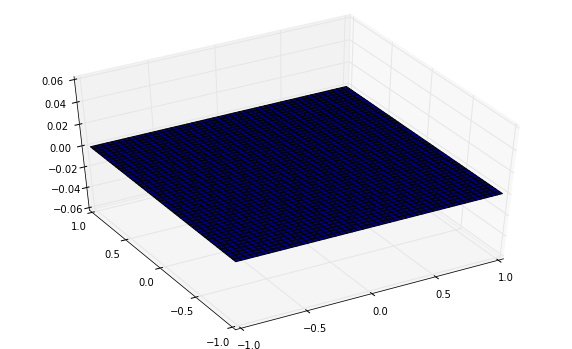

In [32]:
partitions_num=int(input('enter number of partitions: '))
#samples=int(input('enter number of samples: '))
samples=50
gen_plot(partitions_num,samples)
